In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
    )
    test_img2 = transform(
        Image.open("test_examples/child.jpg").convert("RGB")
    ).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
    )
    test_img3 = transform(Image.open("test_examples/bus.png").convert("RGB")).unsqueeze(
        0
    )
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
    )
    test_img4 = transform(
        Image.open("test_examples/boat.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
    )
    test_img5 = transform(
        Image.open("test_examples/horse.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
    )
    model.train()


def save_checkpoint(state, path="inception-RESNET/"):
    print("=> Saving checkpoint")
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
    torch.save(state, path+'/my_checkpoint.pth.tar')


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

/home/kumar/anaconda3/envs/zeggs/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
train_file = "Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt"
test_file = "Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt"
val_file = "Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt"

In [3]:
train_file = pd.read_csv(train_file,sep = '\t',names =['image'])
test_file = pd.read_csv(test_file,sep = '\t',names =['image'])
val_file = pd.read_csv(val_file,sep = '\t',names =['image'])

In [4]:
training_files = train_file['image'].tolist()+test_file['image'].tolist()

In [5]:
from os import listdir
from os.path import isfile, join
mypath = "Flickr8K/Flicker8k_Images/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
captions_file = "Flickr8K/Flickr8k_text/Flickr8k.token.txt"
df = pd.read_csv(captions_file,sep = '\t',header = None,names = ['image','caption'])
df['image'] = df["image"].str.split('#', 1, expand=True)[0]

In [7]:
df = df[df['image'].isin(onlyfiles)]

In [8]:
df_train = df[df['image'].isin(training_files)]
df_test = df[df['image'].isin(val_file['image'].tolist())]

In [9]:
df_train = df_train.reset_index(drop = True)

In [10]:
df_test = df_test.reset_index(drop = True)

In [11]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import re


# We want to convert text -> numerical values
# 1. We need a Vocabulary mapping each word to a index
# 2. We need to setup a Pytorch dataset to load the data
# 3. Setup padding of every batch (all examples should be
#    of same seq_len and setup dataloader)
# Note that loading the image is very easy compared to the text!

# Download with: python -m spacy download en
#import spacy.cli
#spacy.cli.download("en_core_web_lg")
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        #df = pd.read_csv(captions_file,sep = '\t',header = None,names = ['image','caption'])
        #df['image'] = df['image'].apply(lambda x: re.sub('#\d','',x))
        #df['image'] = df['image'].apply(lambda x: re.sub('\.\d','',x))
        self.df = captions_file
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


if __name__ == "__main__":
    transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

    loader, dataset = get_loader(
        "Flickr8K/Flicker8k_Images/",df_train, transform=transform
    )

    for idx, (imgs, captions) in enumerate(loader):
        print(imgs.shape)
        print(captions.shape)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

2023-05-15 21:22:07.764619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


torch.Size([32, 3, 224, 224])
torch.Size([28, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([33, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
torch.Size([32, 3, 224, 224])
torch.Size([26, 32])
torch.Size([32, 3, 224, 224])
torch.Size([19, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
t

In [12]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.aux_logits = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [13]:
import matplotlib.pyplot as plt
import numpy as np
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

/home/kumar/anaconda3/envs/zeggs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kumar/anaconda3/envs/zeggs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: classic sunglasses sunglasses dragging pug miami stretched 4 begging motorbike her framed twirling smoking enclosed league rock badminton lined bridge prepare sporting sporting after runs hard strange stone horizontal marathon knee sets motorcyclist numerous bounding pool smaller smaller smaller smaller smaller smaller smaller smaller smaller smaller smaller smaller smaller smaller
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: thumb for pot numerous overalls snowbank bungee card fence pads numerous inspecting pop rock sporting sporting teen bed tongue bat groomsmen bulldog kayaking hurdles kayaking compete official snowboarder yawning spiky runs misty theater fruit has telescope crane cream cream snowbank steering his soaked lips prepare sporting sporting low low "
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: thumb gathers dancers for pot player computer direction hurdles rink 

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is running through the water . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is running through the water . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is running through the water . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is running through the water . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a blue shirt is standing on a beach . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a beach . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a beach . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a beach . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a beach . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a beach . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a beach . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a beach . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is jumping over a rock . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a red ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt and a black hat is standing on a sidewalk . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a rock overlooking a <UNK> . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a red shirt is jumping into a pool . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red jacket is jumping over a large wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young girl in a pink shirt is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red jacket is jumping over a ramp . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing on a sidewalk . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the snow . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a blue shirt is jumping over a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black hat is standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a rock overlooking the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is jumping in the air to catch a ball . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red jacket is surfing . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing in a grassy field . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is surfing on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing in the snow . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man and a woman are sitting on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a beach with a stick in his mouth . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing in the snow . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black coat is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on a rocky shore with a stick in its mouth . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a toy . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing in the water . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing in the snow . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is jumping on a trampoline . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a fishing pole in the background . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing in the snow . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is swinging on a swing . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a dock . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man and a woman are sitting on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a stick in his hand . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a woman are walking down a path . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man and a woman are sitting on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a stick in his hand . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a beach . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a grassy field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a wetsuit is surfing on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are playing in the snow . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a fishing pole in the background . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are walking along a rocky beach . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a yellow kayak is surfing . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky shore . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field of flowers . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a group of people are standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a fishing pole in the background . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a snowy mountain . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is running through a field of flowers . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a rocky shore . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky shore . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket and a brown jacket is standing in front of a large building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a yellow kayak is paddling a wave on a beach . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky shore . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog runs through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man and a woman are sitting on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a fishing pole in the background . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a snowy mountain . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man and a woman sit on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a fishing pole in the background . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a beach . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man is standing on a sidewalk with a <UNK> in the background . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach with a sunset in the background . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky shore . <EOS>
=> Saving checkpoint


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink dress is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man and a woman sit on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a rock overlooking the ocean . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a rocky shore . <EOS>
=> Saving checkpoint


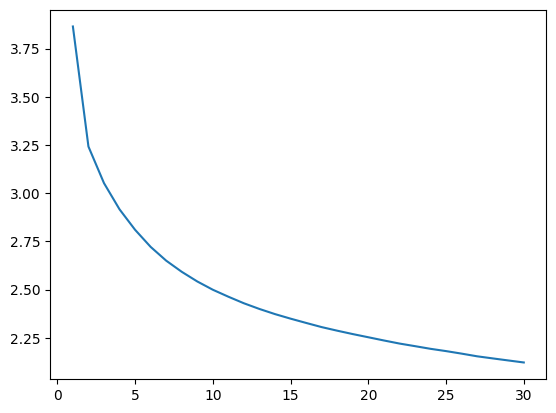

In [14]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
#from utils import save_checkpoint, load_checkpoint, print_examples
#from get_loader import get_loader
#from model import CNNtoRNN


transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
)

train_loader, dataset = get_loader(
        root_folder="Flickr8K/Flicker8k_Images/",
        annotation_file=df_train,
        transform=transform,
        num_workers=2,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_CNN = False

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 30

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.resnet.named_parameters():
  if "fc.weight" in name or "fc.bias" in name:
    param.requires_grad = True
  else:
    param.requires_grad = train_CNN

if load_model:
  step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

model.train()

loss_vals=  []
for epoch in range(num_epochs):
  epoch_loss= []
  running_loss = 0.0
  loss_values = []
  # Uncomment the line below to see a couple of test cases
  print_examples(model, device, dataset)
  if save_model:
    checkpoint = {
                  "state_dict": model.state_dict(),
                  "optimizer": optimizer.state_dict(),
                  "step": step,
            }
    save_checkpoint(checkpoint)

    for idx, (imgs, captions) in tqdm(
              enumerate(train_loader), total=len(train_loader), leave=False):
      imgs = imgs.to(device)
      captions = captions.to(device)

      outputs = model(imgs, captions[:-1])
      loss = criterion(
                  outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )

      writer.add_scalar("Training loss", loss.item(), global_step=step)
      step += 1

      optimizer.zero_grad()
      loss.backward(loss)
      epoch_loss.append(loss.item())
      optimizer.step()
  loss_vals.append(sum(epoch_loss)/len(epoch_loss))
my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)


In [19]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
#from utils import save_checkpoint, load_checkpoint, print_examples
#from get_loader import get_loader
#from model import CNNtoRNN


transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
)

train_loader, dataset = get_loader(
        root_folder="Flickr8K/Flicker8k_Images/",
        annotation_file=df_train,
        transform=transform,
        num_workers=2,
)

In [20]:
test_loader, test_dataset = get_loader(
    root_folder="Flickr8K/Flicker8k_Images/",
    annotation_file=df_test,
    transform=transform,
    num_workers=8,
    shuffle=False,
)

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model.load_state_dict(torch.load("RESNET-LSTM/my_checkpoint.pth.tar")['state_dict'])
#model.load_state_dict(torch.load("../input/flickr8k/my_checkpoint.pth.tar")['state_dict'])
model.eval()

predicted_captions = []
i = 0
for idx, (imgs, captions) in tqdm(
            enumerate(test_loader), total=len(test_loader), leave=False
        ):
    for k in range(imgs.shape[0]):
        img = imgs[k].unsqueeze(0)
        real_caption = [dataset.vocab.itos[j.item()] for j in captions[:, k]]
        predicted_captions.append([model.caption_image(img.to(device), dataset.vocab), real_caption])
        i += 1

/home/kumar/anaconda3/envs/zeggs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kumar/anaconda3/envs/zeggs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
i = 0
references_corpus = []
candidate_corpus = []
for e in predicted_captions:
    if i % 5 == 0:
       #if i < 21:
            #print('Image name: {}'.format(test_dataset.df['image'][i]))
            #print('Real caption: ', [ e for e in predicted_captions[i][1] if e != '<PAD>'])
            #print('Predicted caption: ', [ e for e in predicted_captions[i][0] if e != '<PAD>'])
            #print('\n')
        references_corpus.append([[ e for e in predicted_captions[i][1] if e != '<PAD>']])
        candidate_corpus.append([ e for e in predicted_captions[i][0] if e != '<PAD>'])
        
    else:
        references_corpus[i//5].append([ e for e in predicted_captions[i][1] if e != '<PAD>'])
        
    i+=1

In [39]:
from torchtext.data.metrics import bleu_score
print("THE BLEU SCORE IS:",bleu_score(candidate_corpus, references_corpus))

THE BLEU SCORE IS: 0.25780464224113325


In [ ]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 7.5 MB/s eta 0:00:00a 0:00:01


In [28]:
from nltk.translate.meteor_score import meteor_score

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/kumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
score = 0
for i in range(0,1000):
    reference = references_corpus[i]
    reference_text = [[' '.join(i)] for i in reference]
    candidate = candidate_corpus[i]
    candidate_text = " ".join(candidate)
    score+=meteor_score(reference,candidate)
    #print(score)
    

In [37]:
print("THE METEOR SCORE IS:",score/1000)

THE METEOR SCORE IS: 0.27656761163861


In [ ]:
candidate_text

'<SOS> a man in a red shirt is jumping on a <UNK> . <EOS>'